In [78]:
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
#import memory_profiler
from packaging.version import parse as parse_version
from memory_profiler import profile

# Load the memory_profiler extension
#get_ipython().run_line_magic('load_ext', 'memory_profiler')

from pathlib import Path

#import TSNE from sklearn
from sklearn.manifold import TSNE

In [40]:
import black
import jupyter_black

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

jupyter_black.load(line_length=79)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-25 16:50:36CEST

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

sklearn: 1.5.1

numpy        : 2.0.0
sklearn      : 1.5.1
scipy        : 1.14.0
pandas       : 2.2.2
matplotlib   : 3.9.1
jupyter_black: 0.3.4
black        : 24.4.2

Watermark: 2.4.3



In [41]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [42]:
plt.style.use("../matplotlib_style.txt")

In [43]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [44]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [c if c[-1] != "+" and c[-1] != "-" else c[:-1] for c in meta["Cre"].values]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [np.unique(meta["Date"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [np.unique(meta["Mouse age"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [np.unique(meta["Mouse"].values[sliceids == s]).size == 1 for s in sliceids]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [45]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [46]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [120]:
cluster_colors = np.load(data_path / "cluster_colors.npy")


In [125]:
print(cluster_colors.shape)
print(cluster_colors)

(1329,)
['#0D5D7E' '#4A9F93' '#58D2C1' ... '#0D5D7E' '#aaaaaa' '#E62A5D']


In [50]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [51]:
rna_type.shape

(1329,)

In [128]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)
print(dict_rna_type_colors.keys())
print(dict_rna_type_colors["Lamp5 Pax6"])
COLORS = dict_rna_type_colors.values()
print(dict_rna_type_colors.values())

dict_keys(['Lamp5 Pax6', 'Lamp5 Egln3_1', 'Lamp5 Egln3_2', 'Lamp5 Egln3_3', 'Lamp5 Pdlim5_1', 'Lamp5 Pdlim5_2', 'Lamp5 Slc35d3', 'Lamp5 Lhx6', 'Sncg Col14a1', 'Sncg Slc17a8', 'Sncg Calb1_1', 'Sncg Calb1_2', 'Sncg Npy2r', 'Vip Sncg', 'Vip Serpinf1_1', 'Vip Serpinf1_2', 'Vip Serpinf1_3', 'Vip Htr1f', 'Vip Gpc3', 'Vip C1ql1', 'Vip Mybpc1_2', 'Vip Mybpc1_1', 'Vip Chat_1', 'Vip Mybpc1_3', 'Vip Chat_2', 'Vip Igfbp6_1', 'Vip Igfbp6_2', 'Sst Chodl', 'Sst Penk', 'Sst Myh8_1', 'Sst Myh8_2', 'Sst Myh8_3', 'Sst Htr1a', 'Sst Etv1', 'Sst Pvalb Etv1', 'Sst Crhr2_1', 'Sst Crhr2_2', 'Sst Hpse', 'Sst Calb2', 'Sst Pappa', 'Sst Pvalb Calb2', 'Sst C1ql3_1', 'Sst C1ql3_2', 'Sst Tac2', 'Sst Th_1', 'Sst Th_2', 'Sst Th_3', 'Pvalb Gabrg1', 'Pvalb Egfem1', 'Pvalb Gpr149', 'Pvalb Kank4', 'Pvalb Calb1_1', 'Pvalb Calb1_2', 'Pvalb Reln', 'Pvalb Il1rapl2', 'Pvalb Vipr2_1', 'Pvalb Vipr2_2', 'L2/3 IT_1', 'L2/3 IT_2', 'L2/3 IT_3', 'L4/5 IT_1', 'L4/5 IT_2', 'L5 IT_1', 'L5 IT_2', 'L5 IT_3', 'L5 IT_4', 'L6 IT_1', 'L6 IT_2'

In [126]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [54]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str) # features names
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [names2ephys[c] if c in names2ephys else ephysData[0] * np.nan for c in cells]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [118]:
print(cells)

['20171204_sample_2' '20171204_sample_4' '20171204_sample_5' ...
 '20200316_sample_1' '20200316_sample_2' '20200316_sample_3']


In [55]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [56]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

## Electrophysiological t-SNE

In [93]:
# PCA of ephys data
PCinit = PCA(n_components=2, svd_solver="full").fit_transform(ephysData_filtered)
PCinit = PCinit / np.std(PCinit, axis=0) * 0.0001

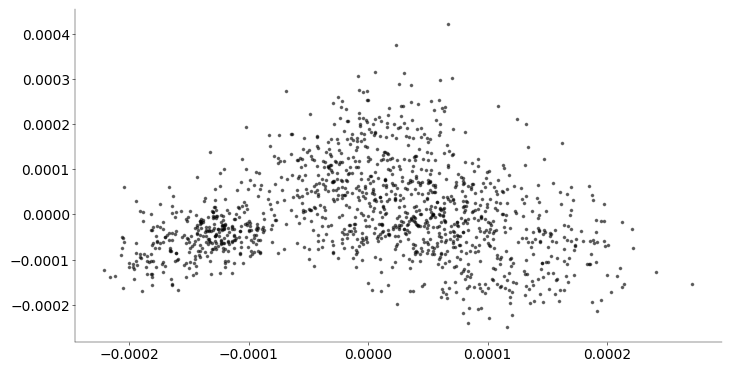

In [105]:
plt.scatter(PCinit[:, 0], PCinit[:, 1], s=10, c="black", alpha=0.5)

In [139]:
# tSNE of ephys data
from sklearn.manifold import TSNE as TSNE_sk

tsne_sk = TSNE_sk()
Z = tsne_sk.fit_transform(ephysData_filtered)

print(Z.shape)

(1320, 2)


# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

1) 

electrophysiology data: sparsity, activity, mean per neuron, (comparrison and enrichment study, gene ontology scores)
vulcano plots, get morphological data, 

3) cebra

[264.97393209 138.57627278 435.15259266 ...   9.30473791  11.06779541
   9.80271276]


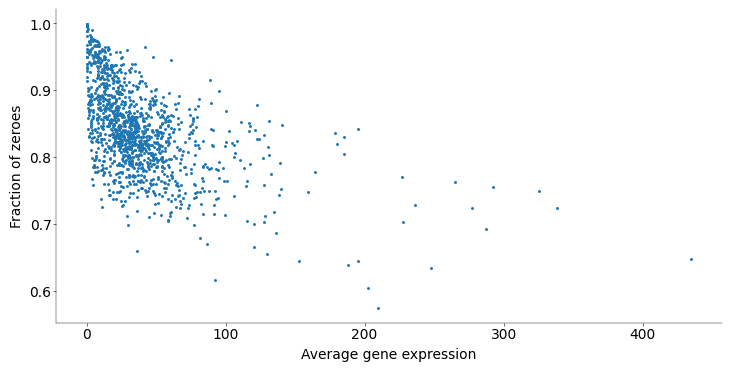

In [57]:
# calculate the average gene expression for each cell
average_gene_expression = np.mean(exonCounts, axis=1)
print(average_gene_expression)
# compute the fraction of zeroes for each cell
fraction_zeroes = np.sum(exonCounts == 0, axis=1) / exonCounts.shape[1]

# plot the average gene expression against the fraction of zeroes
plt.figure()
plt.scatter(average_gene_expression, fraction_zeroes, s=5)
plt.xlabel("Average gene expression")
plt.ylabel("Fraction of zeroes")
plt.show()

In [58]:
# normalise the data with house keeping genes
# find a gene called "Actb" and "Gapdh" in the exon counts
genes = data_exons.index
housekeeping = ["Actb"]
print(np.where(genes == housekeeping[0]))
print(genes[2624])

# find the index of the housekeeping genes in the gene list
idx_housekeeping = [np.where(genes == hk)[0][0] for hk in housekeeping]
print(idx_housekeeping)

# normalise each sample with the counts of actb
print(exonCounts.shape, exonCounts[:, idx_housekeeping[0]])
# devide all gene expression values for all samples by the corresponding actb gene expression value
exonCounts_norm = exonCounts / exonCounts[:, idx_housekeeping]
print(exonCounts_norm, exonCounts_norm.shape)
# calculate the average gene expression for each cell
average_gene_expression_norm = np.mean(exonCounts_norm, axis=0)
print(average_gene_expression_norm, average_gene_expression_norm.shape)

(array([2624]),)
Actb
[np.int64(2624)]
(1329, 42466) [15011  4819 57490 ...   529  2746  1218]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01411081 ... 0.         0.         0.        ]
 [0.         0.         0.02245608 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02840495 ... 0.         0.         0.        ]
 [0.         0.         0.07307061 ... 0.         0.         0.        ]] (1329, 42466)
[nan nan nan ... nan nan nan] (42466,)


/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_12344/1747302482.py:15: RuntimeWarning: divide by zero encountered in divide
  exonCounts_norm = exonCounts / exonCounts[:, idx_housekeeping]
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_12344/1747302482.py:15: RuntimeWarning: invalid value encountered in divide
  exonCounts_norm = exonCounts / exonCounts[:, idx_housekeeping]


Indices of housekeeping genes: [np.int64(2624), np.int64(8851)]
Normalized exon counts:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02240896 ... 0.         0.         0.        ]
 [0.         0.         0.03847873 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.046875   ... 0.         0.         0.        ]
 [0.         0.         0.09758772 ... 0.         0.         0.        ]]
Average gene expression for each gene:
[1.63305729e-03 2.39638303e-06 2.61305913e-02 ... 2.45451757e-04
 1.88833524e-05 7.36170852e-06]
Shape of normalized exon counts: (1329, 42466)


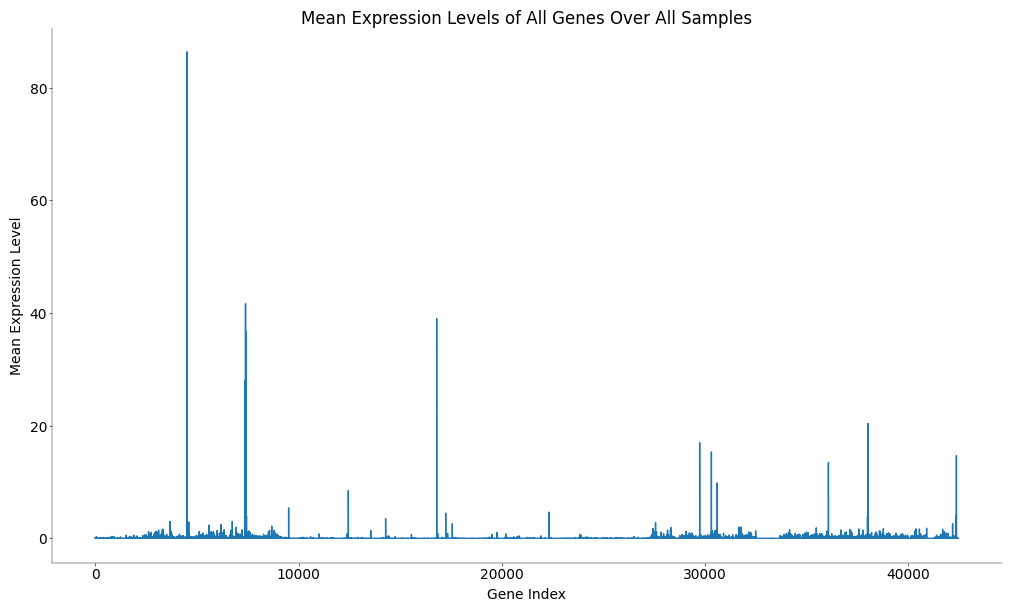

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data structure, replace these with your actual data
# List of housekeeping genes
housekeeping = ["Actb", "Gapdh"]

# Extract the list of genes from the data
genes = data_exons.index

# Find the indices of the housekeeping genes
idx_housekeeping = [np.where(genes == hk)[0][0] for hk in housekeeping]
print(f"Indices of housekeeping genes: {idx_housekeeping}")

# Normalize each sample with the counts of Actb and Gapdh
# Assume exonCounts is a numpy array of shape (number_of_samples, number_of_genes)

# Create an empty array to store normalized counts
exonCounts_norm = np.zeros_like(exonCounts, dtype=float)

# Normalize each sample by the counts of housekeeping genes
for i in range(exonCounts.shape[0]):  # For each sample
    norm_factor = exonCounts[
        i, idx_housekeeping
    ].mean()  # Average counts of housekeeping genes for the sample
    if norm_factor == 0:
        print(
            f"Warning: Zero normalization factor in sample {i}, setting normalization factor to 1 to avoid division by zero."
        )
        norm_factor = 1
    exonCounts_norm[i] = exonCounts[i] / norm_factor

print(f"Normalized exon counts:\n{exonCounts_norm}")

# Calculate the average gene expression for each gene across all samples
average_gene_expression_norm = np.mean(exonCounts_norm, axis=0)
print(f"Average gene expression for each gene:\n{average_gene_expression_norm}")

# The shape of exonCounts_norm is (number_of_samples, number_of_genes)
print(f"Shape of normalized exon counts: {exonCounts_norm.shape}")

# Plot the mean expression levels over all genes
plt.figure(figsize=(10, 6))
plt.plot(average_gene_expression_norm)
plt.xlabel("Gene Index")
plt.ylabel("Mean Expression Level")
plt.title("Mean Expression Levels of All Genes Over All Samples")
plt.show()

In [61]:
# normalisation using bioinfotoolkit
from bioinfokit.analys import norm, get_data

# print head of the data
print("raw data: ", data_exons.head(2))

# using cpm normalization
nm = norm()
nm.cpm(df=data_exons)
# get CPM normalized dataframe
cpm_df = nm.cpm_norm
cpm_df.head(2)


# using rpkm normalization
print(exonLengths, exonLengths.shape)

# add gene length to the corresponding gene id
# find the matching gene id in data exons and gene data and add the gene length to the data exons
data_genes = pd.read_csv(data_path / "gene_lengths.txt")

data_exons.index.name = "GeneID"

# Perform the merge
merged_exon_data = pd.merge(data_exons, data_genes, on="GeneID", how="left")
merged_exon_data.set_index("GeneID", inplace=True)
# Print the head of the merged data
print("merged: ", merged_exon_data.head(2))

nm.rpkm(df=merged_exon_data, gl="exon_bp")

# get RPKM normalized dataframe
rpkm_df = nm.rpkm_norm

print("RPKM normalized data: ", rpkm_df.head(2))

# using tpm normalization

nm.tpm(df=merged_exon_data, gl="exon_bp")

# get TPM normalized dataframe
tpm_df = nm.tpm_norm

print("TPM normalized data: ", tpm_df.head(2))

raw data:                 20171204_sample_2  20171204_sample_4  20171204_sample_5  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   

               20171204_sample_6  20171207_sample_1  20171207_sample_2  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                 13   

               20171207_sample_6  20171207_sample_7  20171219_sample_1  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   

               20171219_sample_2  ...  20191114_sample_9  20200106_sample_1  \
0610005C13Rik                  0  ...                  0                  0   
0610006L08Rik                  0  ...                  0                  0   

               20200106_sample_4  20200106_sample_5  20200106_sample_6  \
0610005C

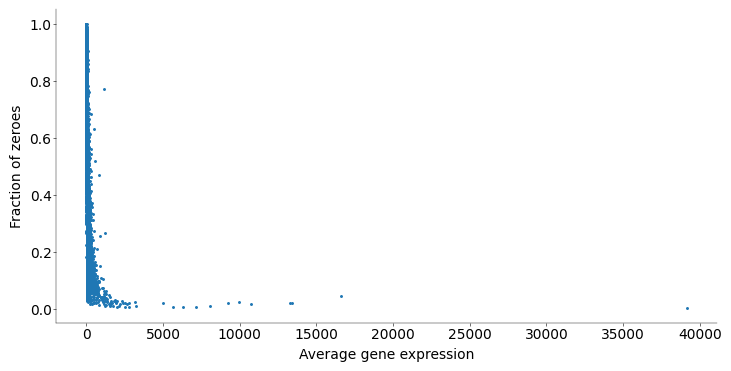

In [62]:
### for the cpm data

cpm_exonCounts = cpm_df.values.transpose()

# calculate the average gene expression for each cell
average_gene_expression_cpm = np.mean(cpm_exonCounts, axis=0)

# compute the fraction of zeroes for each cell
fraction_zeroes_cpm = np.mean(cpm_exonCounts == 0, axis=0)

# plot the average gene expression against the fraction of zeroes
plt.figure()
plt.scatter(average_gene_expression_cpm, fraction_zeroes_cpm, s=5)
plt.xlabel("Average gene expression")
plt.ylabel("Fraction of zeroes")
# make the plot loglog
# plt.xscale("log")
# plt.yscale("log")

plt.show()

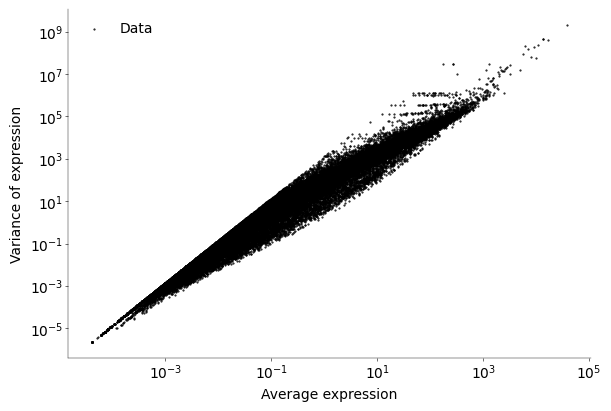

In [63]:
# Compute the variance of the expression counts of each gene
variance_gene_expression = np.var(cpm_exonCounts, axis=0)

fig, ax = plt.subplots(figsize=(6, 4))


ax.scatter(
    average_gene_expression_cpm,
    variance_gene_expression,
    s=1,
    color="black",
    label="Data",
)

# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Variance of expression")
# add legend
ax.legend()

# make axis logarithmix
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_12344/1867521566.py:2: RuntimeWarning: invalid value encountered in divide
  fano_factor = variance_gene_expression / average_gene_expression_cpm


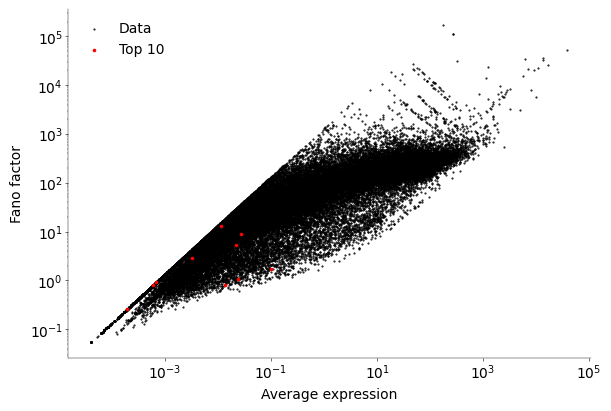

In [64]:
# compute the fano factor
fano_factor = variance_gene_expression / average_gene_expression_cpm

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(average_gene_expression_cpm, fano_factor, s=1, color="black", label="Data")
top10 = np.argsort(~np.isnan(fano_factor))[-10:]
# mark the top 10 fanofactors red
ax.scatter(
    average_gene_expression_cpm[top10],
    fano_factor[top10],
    s=10,
    color="red",
    label="Top 10",
)

# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Fano factor")
# add legend
ax.legend()

# make axis logarithmic
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

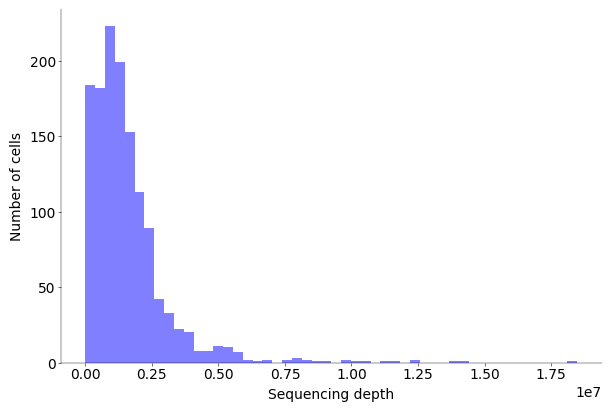

In [65]:
# plot sequencing depth
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(exonCounts.sum(axis=1), bins=50, color="blue", alpha=0.5)
# add labels
ax.set_xlabel("Sequencing depth")
ax.set_ylabel("Number of cells")
plt.show()

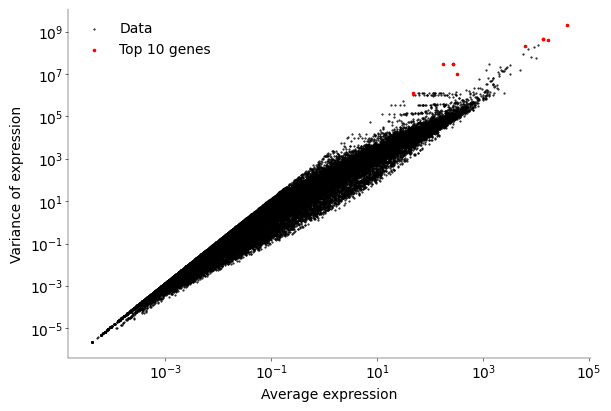

In [66]:
# Exclude NaNs from fano_factor
valid_indices = ~np.isnan(fano_factor)

# Get non-NaN Fano factors and their corresponding indices
valid_fano_factors = fano_factor[valid_indices]
valid_genes = np.array(genes)[valid_indices]
valid_average_gene_expression_cpm = average_gene_expression_cpm[valid_indices]
valid_variance_gene_expression = variance_gene_expression[valid_indices]

# Sort the non-NaN Fano factors in descending order
sorted_indices = np.argsort(-valid_fano_factors)

# Select the top 10 genes
top10_indices = sorted_indices[:10]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for all data
ax.scatter(
    valid_average_gene_expression_cpm,
    valid_variance_gene_expression,
    s=1,
    color="black",
    label="Data",
)

# Highlight the top 10 genes
ax.scatter(
    valid_average_gene_expression_cpm[top10_indices],
    valid_variance_gene_expression[top10_indices],
    s=10,
    color="red",
    label="Top 10 genes",
)

# Add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Variance of expression")
# Add legend
ax.legend()

# Make axis logarithmic
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [67]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest

# Find indices of non-NaN values
valid_indices = ~np.isnan(fano_factor)

# Get non-NaN Fano factors and their corresponding indices
valid_fano_factors = fano_factor[valid_indices]
valid_genes = np.array(genes)[valid_indices]

# Sort the non-NaN Fano factors in descending order
sorted_indices = np.argsort(-valid_fano_factors)

# Print the top 10 genes with the highest normalized Fano factor
print("Top 10 genes with the highest normalized Fano factor:")
for i in range(10):
    print(
        f"{valid_genes[sorted_indices[i]]}: {valid_fano_factors[sorted_indices[i]]:.2f}"
    )

# Give max value of the Fano factor excluding NaNs
max_fano = np.nanmax(fano_factor)
print("Max Fano factor:", max_fano)

Top 10 genes with the highest normalized Fano factor:
Nectin2: 169717.99
Scai: 113449.80
Thoc2: 109742.37
CT010467.1: 52284.37
ERCC-00130: 35841.41
Rn7s1: 34081.25
ERCC-00074: 32902.02
Mir6236: 31180.47
Atg10: 27783.79
Gm26917: 25380.96
Max Fano factor: 169717.99145220438


In [68]:
# log-transform the data
log_counts = np.log1p(exonCounts)

# Square root transform the data
sqrt_counts = np.sqrt(exonCounts)

# Transform the counts into normalized counts (as above)
normalized_counts = cpm_df.values.transpose()

# Select all genes with the normalized Fano factor above 3 and remove the rest
selected_genes = genes[fano_factor > 3]

In [69]:
from sklearn.decomposition import PCA

# perform PCA

pca = PCA()
pca.fit(normalized_counts)
pca_counts = pca.transform(normalized_counts)

pca_log = PCA()
pca_log.fit(log_counts)
pca_log_counts = pca.transform(log_counts)

pca_sqrt = PCA()
pca_sqrt.fit(sqrt_counts)
pca_sqrt_counts = pca.transform(sqrt_counts)


# get the first 2 principal components
pca_counts_2 = pca_counts[:, :2]
pca_log_counts_2 = pca_log_counts[:, :2]
pca_sqrt_counts_2 = pca_sqrt_counts[:, :2]

pcas = [pca_counts_2, pca_log_counts_2, pca_sqrt_counts_2]

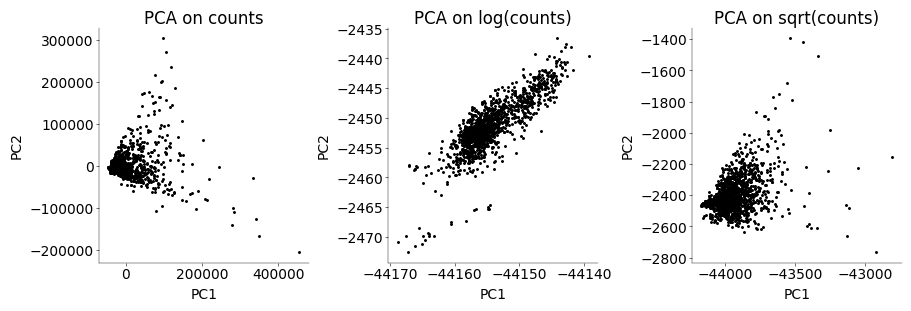

In [71]:
# plot pca results
fig, axs = plt.subplots(1, 3, figsize=(9, 3))


# add labels
for ax in axs:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# plot the data
for i, pca in enumerate(pcas):
    axs[i].scatter(pca[:, 0], pca[:, 1], s=5, color="black")


# add title
axs[0].set_title("PCA on counts")
axs[1].set_title("PCA on log(counts)")
axs[2].set_title("PCA on sqrt(counts)")


plt.show()

In [79]:
# from openTSNE import TSNE

# Apply t-SNE to the 50 PCs
tsne = TSNE()
tsne_counts = tsne.fit(pca_counts[:, :50])

tsne_log = TSNE(n_components=2, random_state=42)
tsne_log_counts = tsne.fit(pca_log_counts[:, :50])

tsne_sqrt = TSNE(n_components=2, random_state=42)
tsne_sqrt_counts = tsne.fit(pca_sqrt_counts[:, :50])


tsnes = [tsne_counts, tsne_log_counts, tsne_sqrt_counts]


# Use default settings of openTSNE


# You can also use sklearn if you want

from sklearn.manifold import TSNE as TSNE_sk

tsne_sk = TSNE_sk()
tsne_counts_sk = tsne_sk.fit_transform(pca_counts[:, :50])
tsne_log_counts_sk = tsne_sk.fit_transform(pca_log_counts[:, :50])
tsne_sqrt_counts_sk = tsne_sk.fit_transform(pca_sqrt_counts[:, :50])

tsnes_sk = [tsne_counts, tsne_log_counts, tsne_sqrt_counts]

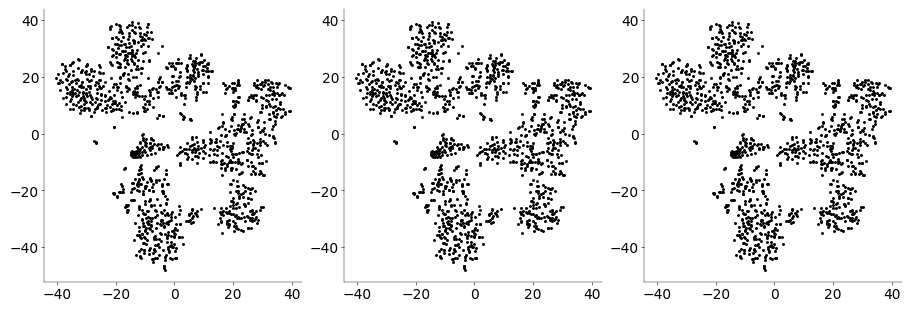

In [91]:
# plot the tsne data
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    axs[i].scatter(
        tsnes[i].embedding_[:, 0], tsnes[i].embedding_[:, 1], s=5, color="black"
    )

plt.show()

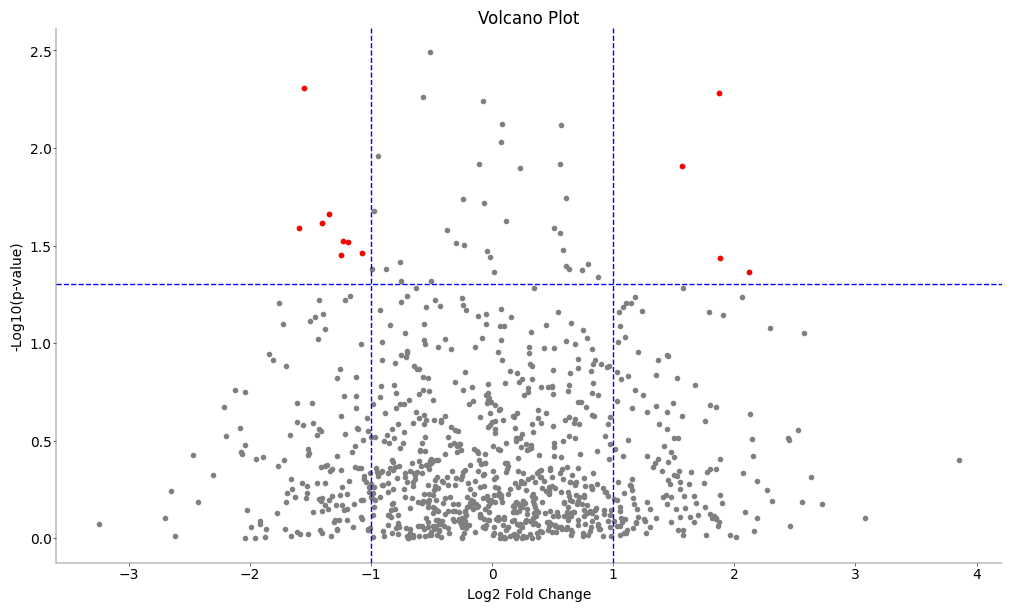

In [87]:
# dummy vulcano plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Generate a dummy dataset
n = 1000
data = pd.DataFrame(
    {"log_fold_change": np.random.randn(n), "p_value": np.random.rand(n)}
)

# Calculate -log10(p-value)
data["-log10(p-value)"] = -np.log10(data["p_value"])

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(data["log_fold_change"], data["-log10(p-value)"], color="grey")

# Highlight significant points
significant = (data["p_value"] < 0.05) & (abs(data["log_fold_change"]) > 1)
plt.scatter(
    data.loc[significant, "log_fold_change"],
    data.loc[significant, "-log10(p-value)"],
    color="red",
)

# Adding labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot")

# Adding threshold lines
plt.axhline(y=-np.log10(0.05), color="blue", linestyle="--")
plt.axvline(x=-1, color="blue", linestyle="--")
plt.axvline(x=1, color="blue", linestyle="--")

plt.show()